# Quantitative duplication HOG analysis

## Whole genome duplication detection

### Importing packages 

In [1]:
# Importing packages
import pyham # pyham package for ham analysis
import pandas as pd # pandas for dataframes
import numpy as np


# PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from Bio import Phylo # Draw phylogenetic tree

### Ham analysis

Set the path to your preferred .nwk species tree file and orthoxml HOG file. 

In [2]:
#  Select a nwk file as a taxonomy reference
nwk_path = "./EstimatedSpeciesTree.nwk"
#  And extract the newick tree as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")

# Then you select your favorite orthoXML file
orthoxml_path =  "./HierarchicalGroups.orthoxml"

In [3]:
# pyham.Ham is the main object that containes all information and functionalities.
ham_analysis = pyham.Ham(nwk_path, orthoxml_path, use_internal_name=False, tree_format='newick')

### Ham analysis on whole OMA set 2021

In [4]:
# import timeit 
# start = timeit.default_timer()

# #  Select a nwk file as a taxonomy reference
# nwk_path = "./speciestree.nwk"
# #  And extract the newick tree as a string
# tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")

# # Then you select your favorite orthoXML file
# orthoxml_path =  "./oma-hogs.orthoXML"

# # ham_analysis =pyham.Ham(nwk_path, orthoxml_path, use_internal_name=True, tree_format="newick", species_resolve_mode="OMA")

# stop = timeit.default_timer()

# print('Time: ', stop - start) 



### Main class
This class traverses the tree starting from the root and maps nodes vertically. Adjusted number of events can be obtained from this mapping as list or as pandas dataframe.

**only_direct = True** if one wants to compare only directly connected nodes (single branch)

**adjust_d = True** if one wants to adjust the number of events by distance (nb_events/(distance+pseudocount))

**adjust_s = True** if one wants to adjust the number of events by the average number of genes (average between compared nodes)

**pscount = 1** Pseudocount set to 1 as default

In [5]:
class ham_all_nodes_mapping:
    def __init__(self, ham_analysis, only_direct = True, adjust_d = True, adjust_s = True, pscount = 1):
        self.list_mapping = [] # To store all pyham.mapper.MapVertical
        self.only_direct = only_direct #Boolean, if true only closest nodes are compared, if false all-against-all
        self.adjust_d = adjust_d #Boolean, if true nb_events are adjusted by the distance
        self.adjust_s = adjust_s #Boolean, if true nb_events are adjusted by the average genome_size
        self.pscount = pscount #Pseudocount
        
        # Get information 
        for parent_node in ham_analysis.taxonomy.tree.traverse():  # Iterating over nodes in tree
            if self.only_direct: # Checks if user wants to map only directly related nodes
                descendant_list = parent_node.children
            else:
                descendant_list = parent_node.get_descendants()   
                
            for child_node in descendant_list: # Iterating over descendant list of parent node
                ###### Gene mapping #####
                ext_anc_gene_mapping = ham_analysis.compare_genomes_vertically(parent_node.genome, child_node.genome)
                self.list_mapping.append(ext_anc_gene_mapping) #Add 
                
    def get_list_mapping(self): # Returns list of all generated pyham.mapper.MapVertical
        return(self.list_mapping)
    
    def get_list_nb_events(self): # Returns event information in a list
        # ["ancestor", "descendant", "distance", "duplication_events", "duplication_HOGs", "gained", "retained", "lost"]          
        list_nb_events = []
        for ext_anc_gene_mapping in self.list_mapping:
            temp_list = [] # Create temporary list for each comparison 
            # Get the ancestor and descendant nodes
            ancestor_node = ext_anc_gene_mapping.ancestor
            descendant_node = ext_anc_gene_mapping.descendant
            # Get their names # Remove .name if you want to add no
            temp_list.append(ancestor_node.name) # Get the name of the ancestor (.name can be reomoved to save node)
            temp_list.append(descendant_node.name) # Get the name of the descendant (.name can be reomoved to save node)
            
            ###
            if self.adjust_s:
                genome_size_average = (ancestor_node.get_number_genes()+descendant_node.get_number_genes())/2
            else:
                genome_size_average = 1
            ### Calculate distance between the two nodes, [0] for ancestor [1] for descendant
                #!Attention distance is rounded to 5 decimals 
            distance = round(ham_analysis.taxonomy.tree.get_distance(temp_list[1]) - 
                             ham_analysis.taxonomy.tree.get_distance(temp_list[0]), 5)
            temp_list.append(distance) # Add distance between two nodes
            distance += self.pscount # Add pseudocount to avoid division by small distances
            if not self.adjust_d: # If parament adjust is set to false divide by 1 (not adjusted by distance)
                distance = 1
                
            ### Get event informations
            try:
                # Get number of duplication events
                temp_list.append(ext_anc_gene_mapping.map.number_duplication/distance/genome_size_average) 
                # Get dict of HOGs with duplicated genes
                temp_list.append(len(ext_anc_gene_mapping.get_duplicated())/distance/genome_size_average) 
                # Get dict of HOGs with retained genes
                temp_list.append(len(ext_anc_gene_mapping.get_retained())/distance/genome_size_average) 
                # Get set of HOGs that were lost
                temp_list.append(len(ext_anc_gene_mapping.get_lost())/distance/genome_size_average) 
                # Get list of HOGs/genes that were gained
                temp_list.append(len(ext_anc_gene_mapping.get_gained())/distance/genome_size_average)
                # Appending values to the list that stores all information
                list_nb_events.append(temp_list)
            except ZeroDivisionError: # If species are too close distance = 0, avoid dividing by zero
                temp_list.extend([None, None, None, None, None])
                list_nb_events.append(temp_list)

        return(list_nb_events)
    
    def get_df_nb_events(self): # Returns event information in form of a pandas data frame
        data = self.get_list_nb_events() # Call function to get event information
        df = pd.DataFrame.from_records(data) # List to pandas dataframe
        df.columns = ["ancestor", "descendant", "distance", "duplication_events", # Set column names
                      "duplication_HOGs", "retained", "lost", "gained"]
        return(df)

### Define function

In [6]:
# Function that normalizes data between 0 and 1
def df_min_max_scale(df):
    # apply normalization techniques by Column 1
    list_numeric_values = ["duplication_events", "duplication_HOGs", "retained", "lost", "gained"]
    for column in list_numeric_values:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

### Phylogenetic  tree visualization


In [7]:
# Pyham's "ascii" tree 
print(pyham.utils.previsualize_taxonomy(tree_str))


                                                                                       /-ZYGRO
                                                                                      |
                                                                /ZYGRO/YEAST/YEASA/VANPO                           /-YEAST
                                                               |                      |                 /YEAST/YEASA
                                                               |                       \YEAST/YEASA/VANPO          \-YEASA
                                   /ZYGRO/YEAST/YEASA/VANPO/KLULA                                      |
                                  |                            |                                        \-VANPO
-ZYGRO/YEAST/YEASA/VANPO/KLULA/SCHPO                           |
                                  |                             \-KLULA
                                  |
                                   \-SCHPO


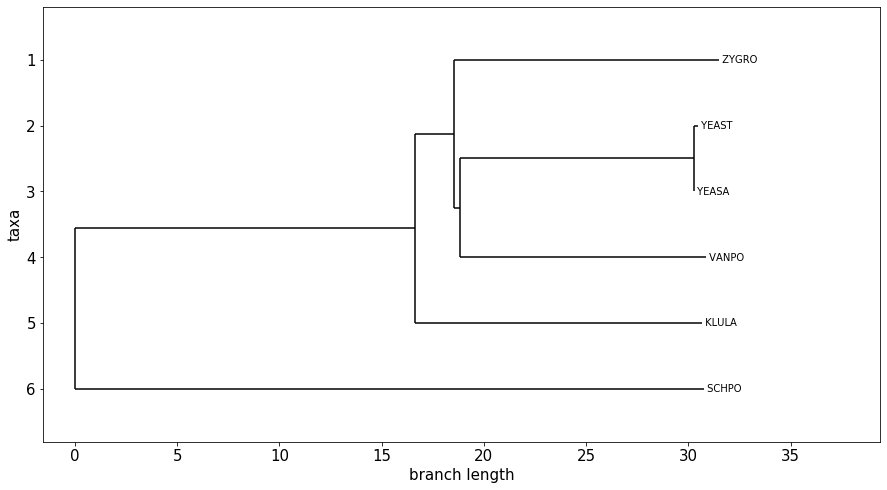

In [8]:
# Plotting parameters
TICKS = 15 # Tick size
LABEL = 15 # Label size

plt.rc('axes', labelsize=LABEL)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICKS)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICKS)    # fontsize of the tick labels

# Biopython's Phylo package tree
plt.rcParams['figure.figsize'] = [15, 8] # Figure size
tree = Phylo.read(nwk_path, "newick")
Phylo.draw(tree, show_confidence = False)

### Setting pandas display options

In [9]:
# Set options to avoid scientific notations 
pd.set_option('display.float_format', lambda x: '%.4f' % x) #Xf to decide how many digits are shown after the .
#pd.reset_option('display.float_format') # Uncomment ot reset default pandas display format 
pd.options.display.max_colwidth = 30

### Run analysis 

In [10]:
# Run the analysis with the ham_all_nodes_mapping class
# Parameters should be adjusted depending on the analysis
Ham_mapping_test = ham_all_nodes_mapping(ham_analysis, adjust_d=True, adjust_s=True, pscount=5)

In [11]:
# Save the informations from the as dataframe
df = Ham_mapping_test.get_df_nb_events()

# Display head and tail of the dataframe
display(df.head()) 
display(df.tail()) 

# Uncomment to scale the values (min-max normalization)
df_min_max_scale(df) 

,ancestor,descendant,distance,duplication_events,duplication_HOGs,retained,lost,gained
0,ZYGRO/YEAST/YEASA/VANPO/KL...,ZYGRO/YEAST/YEASA/VANPO/KLULA,16.6440,0.0030,0.0024,0.0283,0.0000,0.0279
1,ZYGRO/YEAST/YEASA/VANPO/KL...,SCHPO,30.7514,0.0015,0.0011,0.0159,0.0000,0.0203
2,ZYGRO/YEAST/YEASA/VANPO/KLULA,ZYGRO/YEAST/YEASA/VANPO,1.8754,0.0048,0.0042,0.1315,0.0018,0.0128
3,ZYGRO/YEAST/YEASA/VANPO/KLULA,KLULA,14.0297,0.0004,0.0003,0.0452,0.0029,0.0107
4,ZYGRO/YEAST/YEASA/VANPO,ZYGRO,12.9710,0.0008,0.0005,0.0499,0.0053,0.0045


,ancestor,descendant,distance,duplication_events,duplication_HOGs,retained,lost,gained
5,ZYGRO/YEAST/YEASA/VANPO,YEAST/YEASA/VANPO,0.3324,0.0067,0.0064,0.1711,0.0083,0.0051
6,YEAST/YEASA/VANPO,YEAST/YEASA,11.4314,0.0022,0.0018,0.0531,0.0047,0.0051
7,YEAST/YEASA/VANPO,VANPO,12.0059,0.0021,0.0019,0.0476,0.0077,0.0088
8,YEAST/YEASA,YEAST,0.1688,0.0050,0.0031,0.1710,0.0019,0.0319
9,YEAST/YEASA,YEASA,0.0000,0.0019,0.0013,0.1448,0.0872,0.0187


### Main plot

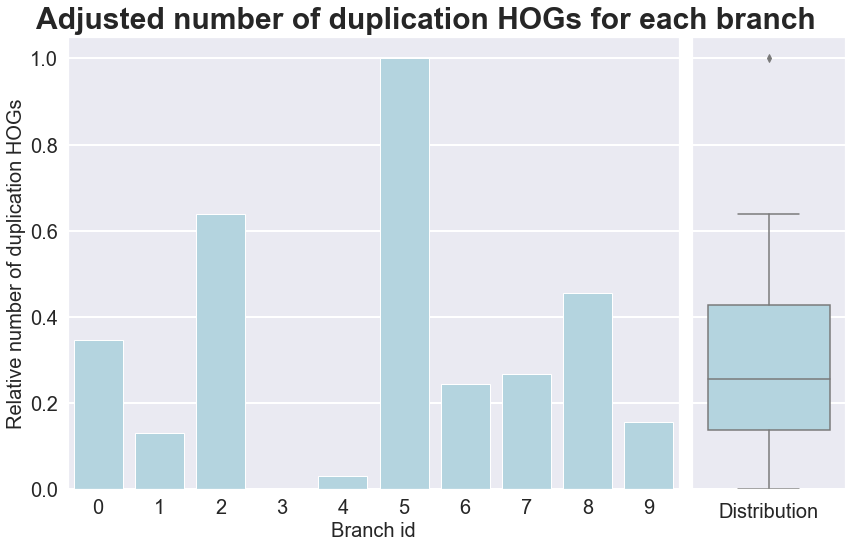

In [12]:
# Set data to plot with distribution (duplication_events, duplication_HOGs, retained, lost, gained)
data_to_plot = "duplication_HOGs"

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
plt.rcParams['figure.figsize'] = [12, 8] # Figure size
sns.set(style="darkgrid")
 
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
fig, (ax_hist, ax_box) = plt.subplots(nrows = 1, ncols = 2, sharey=True, gridspec_kw={"width_ratios": (.80, .20)})
 
# assigning a graph to each ax
sns.boxplot(y = df[data_to_plot], ax=ax_box, color = "lightblue")
sns.barplot(x=df.index, y=data_to_plot, data=df, color = "lightblue", ax=ax_hist)
 
# Plotting parameters
fig.suptitle("Adjusted number of duplication HOGs for each branch", fontsize=30, fontweight = "bold")
ax_box.set_xlabel("Distribution",fontsize=20)
ax_box.set(ylabel='') # Remove y axis name for the boxplot
ax_hist.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax_hist.xaxis.set_major_locator(ticker.MultipleLocator(base=1)) # Tick scale 
ax_hist.set_ylabel("Relative number of duplication HOGs",fontsize=20)
ax_hist.set_xlabel("Branch id",fontsize=20)
ax_hist.tick_params(labelsize=20)
ax_hist.grid(linewidth=2)
ax_hist.xaxis.grid(False)
ax_box.grid(linewidth=2)
ax_box.xaxis.grid(False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Current_fig = plt.gcf()    
plt.show()
Current_fig.savefig('./output/duplication_HOG_plot.png')

### Found WGD candidate(s)

Possible WGD candidate(s) given as ancestor and descendant node names.

In [18]:
# Get IQR (interquartile range) score
Q1 = df["duplication_HOGs"].quantile(0.25)
Q3 = df["duplication_HOGs"].quantile(0.75)
IQR = Q3 - Q1

# # Get the value of the maximum number of (adjusted) duplication HOGs
# set_threshold = 0.8
# max_dup_hog = max(df["duplication_HOGs"])
# threshold = set_threshold*max_dup_hog #Calculate threshold in case not normalized

# Find rows in dataframe that are identified as upper outliers (based on IQR score)
result = df[(df["duplication_HOGs"] > (Q3 + 1.5 * IQR))] 

# Find rows based on set threshold
#result = df[(df["duplication_HOGs"] > threshold)] 

display(result)

# Print the resulting ancestor and descendant node names
result_list = []
for i in range(0, len(result)):
    result_list.append([(result["ancestor"][result.index[i]]),(result["descendant"][result.index[i]])])

for i in result_list:
    print("Possible WGD on branch between:", i, "\n")

,ancestor,descendant,distance,duplication_events,duplication_HOGs,retained,lost,gained
5,ZYGRO/YEAST/YEASA/VANPO,YEAST/YEASA/VANPO,0.3324,1.0000,1.0000,1.0000,0.0953,0.0220


Possible WGD on branch between: ['ZYGRO/YEAST/YEASA/VANPO', 'YEAST/YEASA/VANPO'] 



#### Try multiple pseudocounts
This allows to keep only branches that persist over a range of different pseudocounts.

In [63]:
# Set list of pseudocounts to test
pseudocounts = range(1,5)
# pseudocounts = [1,3,5]

# Repeat analysis with different pseudocounts
results_per_pscount = []
for i in pseudocounts:
    Ham_mapping_test = ham_all_nodes_mapping(ham_analysis, adjust_d=True, adjust_s=True, pscount=i)
    df = Ham_mapping_test.get_df_nb_events()
    Q1 = df["duplication_HOGs"].quantile(0.25)
    Q3 = df["duplication_HOGs"].quantile(0.75)
    IQR = Q3 - Q1
    result = df[(df["duplication_HOGs"] > (Q3 + 1.5 * IQR))] 
    result_id_list = list(result.index.values)
    results_per_pscount.append(list(result.index.values))

# Find intersection between each results
results_intersection = set(results_per_pscount[0]).intersection(*results_per_pscount[1:])

# Print results
print("Most likely WGD branches:\n")
for i in results_intersection:
    print("Branch id", i, "corresponding to the branch between:\n", df["ancestor"][df.index[i]],
    "and\n", df["descendant"][df.index[i]] , "\n")

Most likely WGD branches:

Branch id 5 corresponding to the branch between:
 ZYGRO/YEAST/YEASA/VANPO and
 YEAST/YEASA/VANPO 



### Plotting

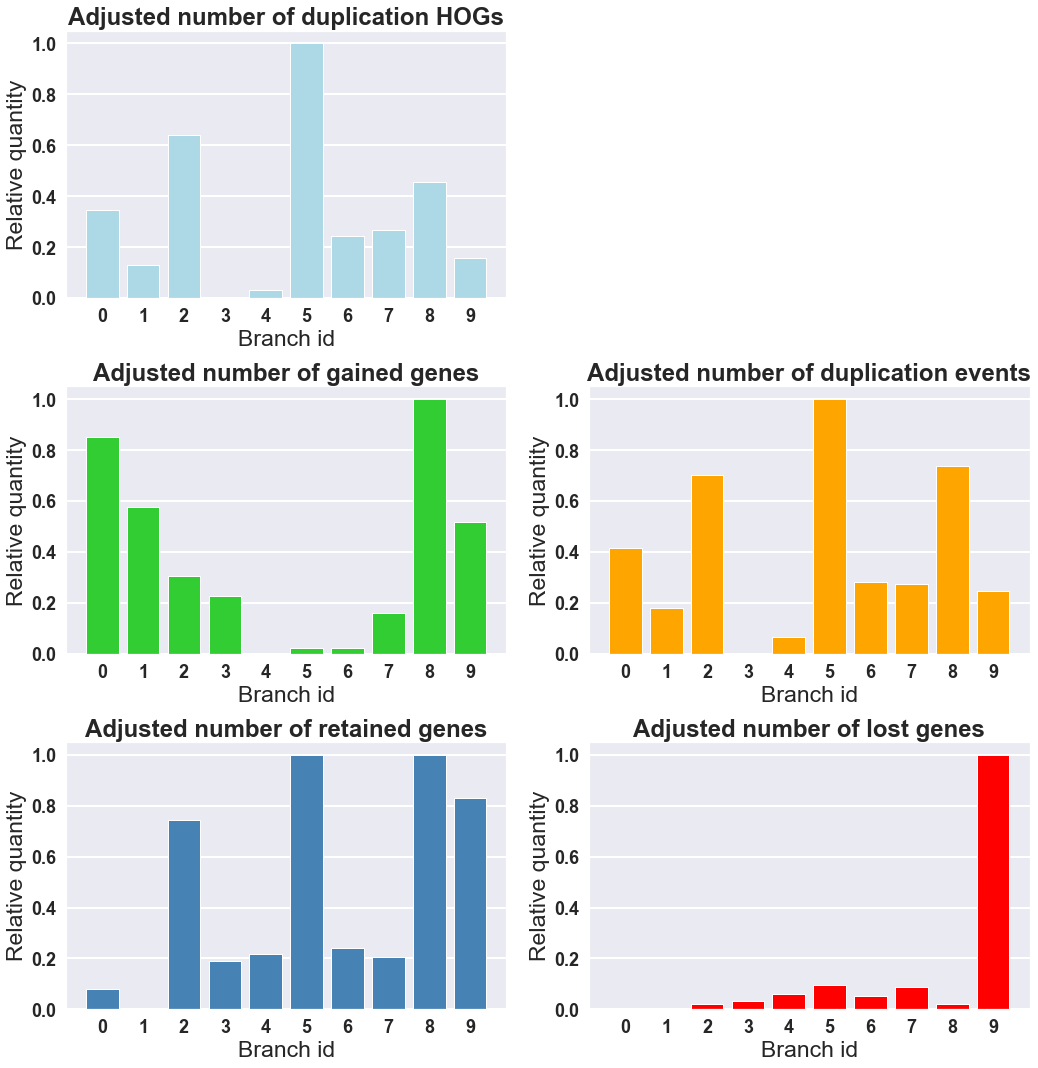

In [14]:
#Plotting parameters
sns.set(style="darkgrid")
TICKS = 18
LABEL = 23
TITLE = 24

plt.rc('axes', titlesize=TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=LABEL)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICKS)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICKS)    # fontsize of the tick labels
plt.rc('font', weight='bold')

# Plot size
plt.rcParams['figure.figsize'] = [15, 15]
# Plotting
fig, axs = plt.subplots(3, 2)
axs[0, 0].bar(range(0,len(df)),height = df["duplication_HOGs"], color = "lightblue")
axs[0, 0].set_title('Adjusted number of duplication HOGs',fontweight='bold')
axs[1, 1].bar(range(0,len(df)),height = df["duplication_events"], color = "orange")
axs[1, 1].set_title('Adjusted number of duplication events',fontweight='bold')
axs[2, 0].bar(range(0,len(df)),height = df["retained"], color = "steelblue")
axs[2, 0].set_title('Adjusted number of retained genes',fontweight='bold')
axs[2, 1].bar(range(0,len(df)),height = df["lost"], color = "red")
axs[2, 1].set_title('Adjusted number of lost genes',fontweight='bold')
axs[1, 0].bar(range(0,len(df)),height = df["gained"], color = "limegreen")
axs[1, 0].set_title('Adjusted number of gained genes',fontweight='bold')
fig.delaxes(axs[0, 1]) # Remove 6th plot


for ax in axs.flat:
    ax.set(xlabel='Branch id', ylabel='Relative quantity')
    ax.set_xticks(np.arange(0, len(df), step=1)) #Ticks can be adjusted here
    ax.grid(linewidth=2)
    ax.xaxis.grid(False)

# Fit the labels     
fig.tight_layout()
 

Current_fig = plt.gcf()    
plt.show()
Current_fig.savefig('./output/overall_plot.png')

#### Adjusted duplicated HOGs distribution

In [19]:
print("Median duplication HOGs:", df["duplication_HOGs"].median())
print("Mean duplication HOGs:", df["duplication_HOGs"].mean())
print("Standard deviation duplication HOGs:", df["duplication_HOGs"].std())
# print("Threshold:", threshold)

Median duplication HOGs: 0.25514022416404014
Mean duplication HOGs: 0.32665724071314317
Standard deviation duplication HOGs: 0.3054933499465849


#### Tree Profile

In [16]:
treeprofile = ham_analysis.create_tree_profile(outfile="./output/tp.html")

from IPython.display import IFrame
IFrame("./output/tp.html", width=1000, height=480)